## Step 1: import files

In [46]:
import cv2
print(cv2.__version__)

4.4.0


In [47]:
# Get filenames in list
from os import listdir
from os.path import isfile, join
mypath = "dataset/phase1/images"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(str(len(file_names)) + ' images loaded')


97 images loaded


## Step 2: Sift and Glcm demo on one example image

47

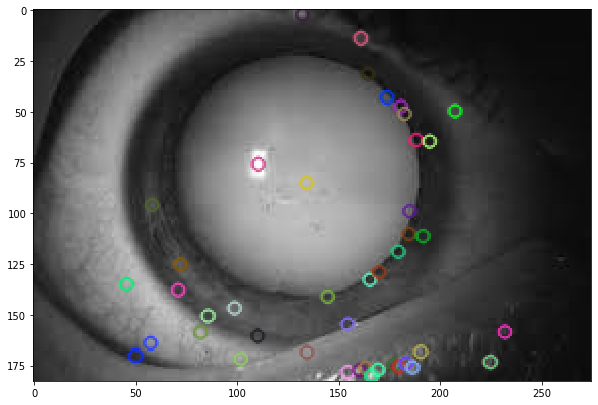

In [48]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
#reading image
img1 = cv2.imread(mypath+"/"+file_names[21])  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(gray1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)
img1.shape
len(keypoints_1)

In [49]:
import numpy as np
from skimage.feature import  greycomatrix, greycoprops
image = cv2.imread(mypath+"/"+file_names[21],0)
img_arr = np.array(image)
gCoMat = greycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')[0][0]
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
energy = greycoprops(gCoMat, prop='energy')[0][0]
correlation = greycoprops(gCoMat, prop='correlation')[0][0]
print("contrast: ",contrast)
print("dissimilarity: ",dissimilarity)
print("homogeneity: ",homogeneity)
print("energy: ",energy)
print("correlation: ",correlation)

contrast:  31.412348929041524
dissimilarity:  3.0875114674324915
homogeneity:  0.4051366064192086
energy:  0.039446946896192533
correlation:  0.9944224409212229


## Step 3: Sift and glcm on full dataset

In [50]:
import cv2
import numpy as np
from skimage.feature import  greycomatrix, greycoprops
images_sift = []
glcm=[]
labels = []
size = 128
sift = cv2.xfeatures2d.SIFT_create()
cataract=0
normal=0
for i, file in enumerate(file_names):
        image = cv2.imread(mypath+"/"+file,0)
        h,w=image.shape
        if(h>128 and w>128):
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            img_arr = np.array(image)
            gCoMat = greycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
            contrast = greycoprops(gCoMat, prop='contrast')[0][0]
            dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
            homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
            energy = greycoprops(gCoMat, prop='energy')[0][0]
            correlation = greycoprops(gCoMat, prop='correlation')[0][0]
            keypoints, descriptors = sift.detectAndCompute(image,None)
            descriptors=np.array(descriptors)
            descriptors=descriptors.flatten()
            glcm.append([contrast,dissimilarity,homogeneity,energy,correlation])
            images_sift.append(descriptors[:2304])

            #print(descriptors.shape)
            if file_names[i][0] == "c":
                cataract+=1
                labels.append(1)
            if file_names[i][0] == "n":
                normal+=1
                labels.append(0)
          
print("Testing and validation split done!")


Testing and validation split done!


In [51]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [52]:
images_sift=np.array(images_sift)
images_sift.shape





(53, 2304)

In [53]:
glcm=np.array(glcm)
images_sift_glcm=np.concatenate((images_sift,glcm),axis=1)
images_sift_glcm.shape

(53, 2309)

## Step 4: Building various  ML models

In [54]:
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


rf_class = RandomForestClassifier(n_estimators=100)
svm_rbf=svm.SVC(kernel='rbf',gamma=0.001,C=10)
svm_linear=svm.SVC(kernel='linear',gamma=0.001,C=10)
knn= KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2) 
log = LogisticRegression(solver='liblinear')

model_names={"Random Forest":rf_class,"SVM RBF":svm_rbf,"SVM_linear":svm_linear,"k nearest neighbor":knn,"logistic regression":log}
    



## Step 5: Testing various model 

In [55]:
def testing(model_name,X_train, X_test, y_train, y_test):
    model=model_names[model_name]
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)
    print(model_name,'\tAccuracy: %.3f' % acc)
    print(confusion_matrix(y_test, yhat))
    print("\n\n")
    
    

In [56]:
def result(dataset):
    #Normalization
    #min_max_scaler = preprocessing.StandardScaler()
    #x_scaled = min_max_scaler.fit_transform(dataset)
    
    
    #panda dataframe 
    df=pd.DataFrame(data=dataset)
    df['label']=labels
    df=df.sample(frac=1)
    X=df.drop(['label'], axis = 1)
    y=df['label']
    
    
    #Different model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    for model in ["Random Forest","SVM RBF","SVM_linear","k nearest neighbor","logistic regression"]:
        testing(model,X_train, X_test, y_train, y_test)
    
    
    
    
    



## Testing Sift features

In [57]:
print("Sift testing..........\n")
result(images_sift)


Sift testing..........

Random Forest 	Accuracy: 0.857
[[4 0]
 [2 8]]



SVM RBF 	Accuracy: 0.786
[[ 1  3]
 [ 0 10]]



SVM_linear 	Accuracy: 0.714
[[3 1]
 [3 7]]



k nearest neighbor 	Accuracy: 0.929
[[ 3  1]
 [ 0 10]]



logistic regression 	Accuracy: 0.714
[[3 1]
 [3 7]]





## GLCM features

In [58]:
print("glcm testing..........\n")
result(glcm)

glcm testing..........

Random Forest 	Accuracy: 0.714
[[6 2]
 [2 4]]



SVM RBF 	Accuracy: 0.500
[[2 6]
 [1 5]]



SVM_linear 	Accuracy: 0.714
[[4 4]
 [0 6]]



k nearest neighbor 	Accuracy: 0.500
[[4 4]
 [3 3]]



logistic regression 	Accuracy: 0.500
[[1 7]
 [0 6]]





## sift and glcm combined features

In [59]:
print("sift and glcm combined testing..........\n")
result(images_sift_glcm)

sift and glcm combined testing..........

Random Forest 	Accuracy: 0.643
[[3 3]
 [2 6]]



SVM RBF 	Accuracy: 0.643
[[1 5]
 [0 8]]



SVM_linear 	Accuracy: 0.857
[[6 0]
 [2 6]]



k nearest neighbor 	Accuracy: 0.929
[[5 1]
 [0 8]]



logistic regression 	Accuracy: 0.857
[[6 0]
 [2 6]]





## Step 6:Predicting.........

In [60]:
import pickle
import cv2
from skimage.feature import  greycomatrix, greycoprops
from sklearn import preprocessing
import numpy as np
log_pickle_model = pickle.load(open("log_model.sav", 'rb'))
sift = cv2.xfeatures2d.SIFT_create()
min_max_scaler = preprocessing.MinMaxScaler()
size=128


In [61]:
def predict_new(imagefile):
    image_test = cv2.imread(mypath+"/"+imagefile,0)
    image_test = cv2.resize(image_test, (size, size), interpolation = cv2.INTER_AREA)
    glcm_test=[]
    images_sift_test=[]
    print(file_names[67])
    img_arr_test = np.array(image_test)
    gCoMat = greycomatrix(img_arr_test, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
    contrast = greycoprops(gCoMat, prop='contrast')[0][0]
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
    homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
    energy = greycoprops(gCoMat, prop='energy')[0][0]
    correlation = greycoprops(gCoMat, prop='correlation')[0][0]
    keypoints, descriptors = sift.detectAndCompute(image_test,None)
    descriptors=np.array(descriptors)
    descriptors=descriptors.flatten()
    glcm_test.append([contrast,dissimilarity,homogeneity,energy,correlation])
    glcm_test=np.array(glcm_test)
    images_sift_test.append(descriptors[:2304])
    images_sift_test=np.array(images_sift_test)
    print(images_sift_test.shape,glcm_test.shape)
    images_sift_glcm_test=np.concatenate((images_sift_test,glcm_test),axis=1)
    print(log_pickle_model.predict(images_sift_glcm_test))



In [62]:
for i in file_names:
    predict_new(i)

normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
normal (57).jpg
(1, 2304) (1, 5)
[1]
n

In [63]:
filename = 'log_model.sav'
log = LogisticRegression(solver='liblinear')
while(True):
    df=pd.DataFrame(data=images_sift_glcm)
    df['label']=labels
    df=df.sample(frac=1)
    X=df.drop(['label'], axis = 1)
    y=df['label']
    #Different model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    log.fit(X_train,y_train)
    yhat = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)
    print(acc*100)
    if(acc>0.97):
        pickle.dump(log, open(filename, 'wb'))
        break

 

    
    
    

100.0


In [64]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))